C:\Users\sinha\AppData\Local\Temp\ipykernel_19848\316463184.py:76: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
C:\Users\sinha\AppData\Local\Temp\ipykernel_19848\316463184.py:76: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
C:\Users\sinha\AppData\Local\Temp\ipykernel_19848\316463184.py:76: DeprecationWarning: The class ``qiski

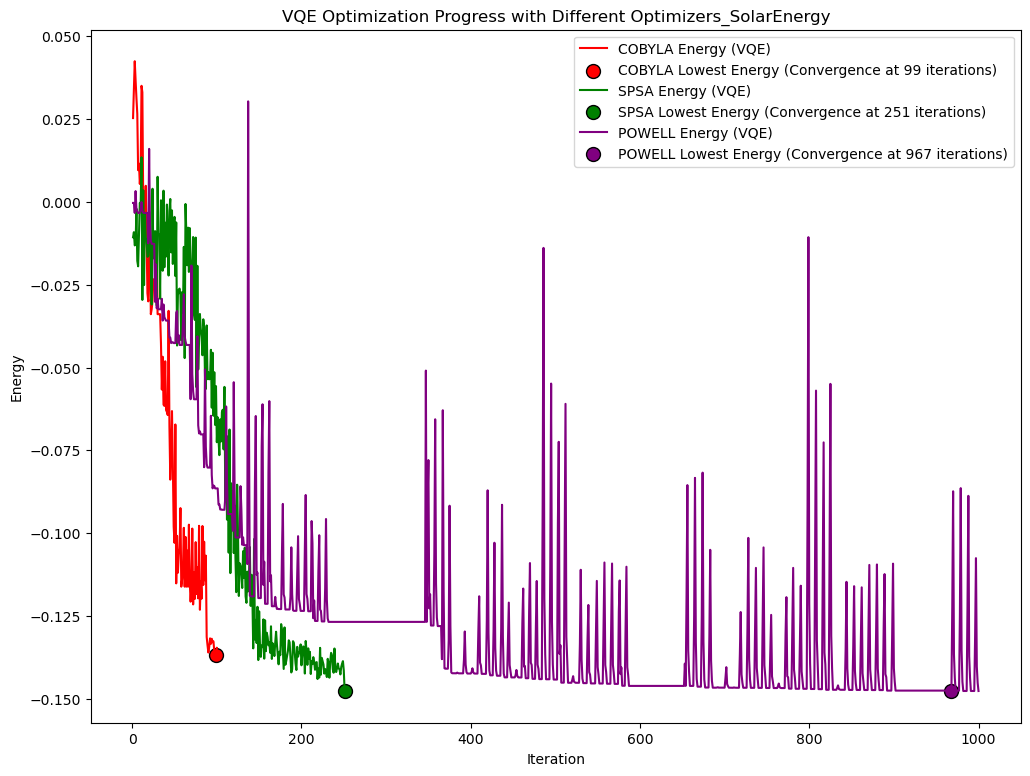


Maximum Eigenvalue Data with Corresponding CSV Rows for Each Optimizer:

Optimizer: COBYLA
  Maximum Eigenvalue: 0.04248234881944799
  Reached at Iteration: 3
  Corresponding CSV Data Point: {'G_theta': 191.0, 'T': 27.0, 'V_oc': 89.74, 'I_sc': 3.7264864}

Optimizer: SPSA
  Maximum Eigenvalue: 0.013463446692611802
  Reached at Iteration: 11
  Corresponding CSV Data Point: {'G_theta': 467.0, 'T': 27.0, 'V_oc': 89.74, 'I_sc': 9.1113568}

Optimizer: POWELL
  Maximum Eigenvalue: 0.030363382429734548
  Reached at Iteration: 137
  Corresponding CSV Data Point: {'G_theta': 674.0, 'T': 28.0, 'V_oc': 89.14, 'I_sc': 13.8544744}


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator 
from qiskit import QuantumCircuit
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import COBYLA, SPSA, POWELL
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Pauli
from qiskit.primitives import Estimator
from qiskit_ibm_runtime import QiskitRuntimeService, Options

# Read CSV File containing values of V_oc, I_sc, T, and G(theta)
csv_file_path = "E:/Solar and Wind Integration/Second Paper/solar_panel_data.csv"
data = pd.read_csv(csv_file_path)

# Extract data columns
V_oc_values = data['V_oc'].values
I_sc_values = data['I_sc'].values
T_values = data['T'].values
G_theta_values = data['G_theta'].values

# Constants for the power output equation
T_ref = 25
G_ref = 1000
R = 0.700
r_s = 18.15
k_V = -0.24
k_I = 0.04

# Objective function to calculate power output
def power_output(V_oc, T, I_sc, G_theta):
    V_adjusted = V_oc - k_V * (T - T_ref)
    I_adjusted = I_sc * (G_theta / G_ref) * (1 + k_I * (T - T_ref))
    impedance_factor = R / (R + r_s)
    power = V_adjusted * I_adjusted * impedance_factor
    return power

# Define operators
V_oc_operator = SparsePauliOp.from_list([("ZIII", 1)])
T_operator = SparsePauliOp.from_list([("IZII", 1)])
I_sc_operator = SparsePauliOp.from_list([("IIZI", 1)])
G_theta_operator = SparsePauliOp.from_list([("IIIZ", 1)])
operator = V_oc_operator + T_operator + I_sc_operator + G_theta_operator
impedance_factor = R / (R + r_s)
operator = impedance_factor * operator

# Set up IBM Quantum service
QiskitRuntimeService.save_account(overwrite=True, channel='ibm_quantum', token='a6681e2bb318b723a9f058a25f8d2f8d457ac8a3e5914aa62b913e5fd3c4e9d0bce3024d003177446b4e22d55fea435d40116913fd252e2acab39203d41d2cbd')
service = QiskitRuntimeService()
backend = service.backend('ibm_sherbrooke')
options = Options(optimization_level=3)

# Track data
iteration_data = {}
convergence_data = {}

def callback(eval_count, parameters, mean, std, optimizer_name):
    if optimizer_name not in iteration_data:
        iteration_data[optimizer_name] = []
    iteration_data[optimizer_name].append((eval_count, mean))

    # Track the lowest energy for convergence detection
    if optimizer_name not in convergence_data:
        convergence_data[optimizer_name] = {"lowest_energy": mean, "iterations_to_convergence": eval_count}
    elif mean < convergence_data[optimizer_name]["lowest_energy"]:
        convergence_data[optimizer_name] = {"lowest_energy": mean, "iterations_to_convergence": eval_count}

    #print(f"Iteration {eval_count} (Optimizer: {optimizer_name}): Energy = {mean}, Parameters = {parameters}")

# Run VQE
def run_vqe(optimizer, optimizer_name):
    iteration_data[optimizer_name] = []
    var_form = TwoLocal(rotation_blocks=['ry', 'rz'], entanglement_blocks='cz', reps=3, entanglement='full')
    estimator = Estimator()
    vqe_instance = VQE(estimator, var_form, optimizer, callback=lambda ec, p, m, s: callback(ec, p, m, s, optimizer_name))
    return vqe_instance.compute_minimum_eigenvalue(operator)

# Optimizers
optimizers = {
    'COBYLA': COBYLA(maxiter=100),
    'SPSA': SPSA(maxiter=100),
    'POWELL': POWELL(options={'maxiter': 100}) 
}

# Run VQE with each optimizer
vqe_results = {}
for optimizer_name, optimizer in optimizers.items():
    vqe_results[optimizer_name] = run_vqe(optimizer, optimizer_name)

# Plot results
colors = {'COBYLA': 'r', 'SPSA': 'g', 'POWELL': 'purple'}
plt.figure(figsize=(12, 9))

for optimizer_name, data in iteration_data.items():
    iterations, energies = zip(*data)
    plt.plot(iterations, energies, label=f'{optimizer_name} Energy (VQE)', color=colors[optimizer_name])

    # Highlight lowest energy point
    lowest_energy = convergence_data[optimizer_name]["lowest_energy"]
    convergence_iteration = convergence_data[optimizer_name]["iterations_to_convergence"]
    plt.scatter(convergence_iteration, lowest_energy, color=colors[optimizer_name], marker='o', s=100, edgecolor='black',
                label=f'{optimizer_name} Lowest Energy (Convergence at {convergence_iteration} iterations)')

plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('VQE Optimization Progress with Different Optimizers_SolarEnergy')
plt.legend()
plt.savefig("vqe_optimization_solar_1o3.svg", dpi=300)
plt.show()

# Classical comparison
classical_power_outputs = [power_output(V_oc, T, I_sc, G_theta) for V_oc, I_sc, T, G_theta in zip(V_oc_values, I_sc_values, T_values, G_theta_values)]


csv_data = pd.read_csv("E:/Solar and Wind Integration/Second Paper/solar_panel_data.csv")

print("\nMaximum Eigenvalue Data with Corresponding CSV Rows for Each Optimizer:")

# Iterate through each optimizer's data
for optimizer_name, data in iteration_data.items():
    iterations, eigenvalues = zip(*data)  # Unpack iterations and eigenvalues
    local_max_eigenvalue = max(eigenvalues)
    local_max_iteration = iterations[eigenvalues.index(local_max_eigenvalue)]
    
    # Map the maximum eigenvalue to the corresponding CSV row
    csv_row_index = local_max_iteration - 1  # Adjust for 0-based indexing
    
    print(f"\nOptimizer: {optimizer_name}")
    print(f"  Maximum Eigenvalue: {local_max_eigenvalue}")
    print(f"  Reached at Iteration: {local_max_iteration}")
    
    if isinstance(csv_data, list):
        # Handle csv_data as a list of rows
        if 0 <= csv_row_index < len(csv_data):
            csv_row = csv_data[csv_row_index]
            print(f"  Corresponding CSV Data Point: {csv_row}")
        else:
            print("  Corresponding CSV Data Point: Not Found (Iteration out of CSV range)")
    elif isinstance(csv_data, pd.DataFrame):
        # Handle csv_data as a pandas DataFrame
        if 0 <= csv_row_index < len(csv_data):
            csv_row = csv_data.iloc[csv_row_index]
            print(f"  Corresponding CSV Data Point: {csv_row.to_dict()}")
        else:
            print("  Corresponding CSV Data Point: Not Found (Iteration out of CSV range)")
    else:
        print("  Unknown CSV Data Format!")



C:\Users\sinha\AppData\Local\Temp\ipykernel_19848\3082694896.py:76: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
C:\Users\sinha\AppData\Local\Temp\ipykernel_19848\3082694896.py:76: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
C:\Users\sinha\AppData\Local\Temp\ipykernel_19848\3082694896.py:76: DeprecationWarning: The class ``qi

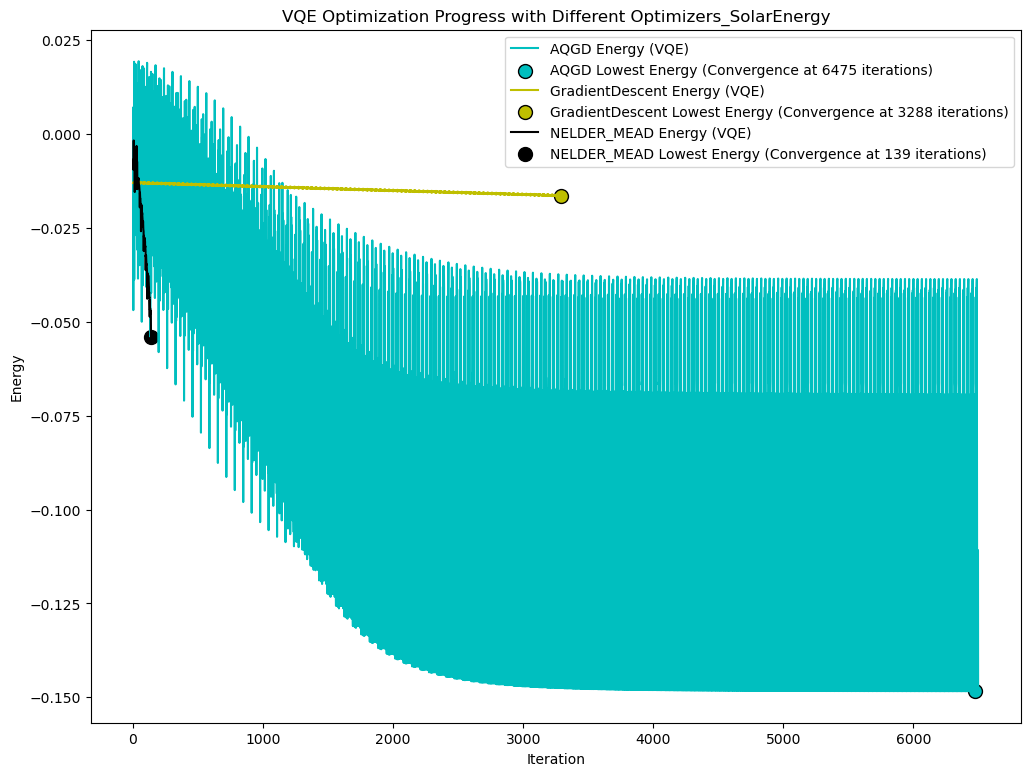


Maximum Eigenvalue Data with Corresponding CSV Rows for Each Optimizer:

Optimizer: AQGD
  Maximum Eigenvalue: 0.019341092627434026
  Reached at Iteration: 44
  Corresponding CSV Data Point: {'G_theta': 738.0, 'T': 31.0, 'V_oc': 87.34, 'I_sc': 17.4841056}

Optimizer: GradientDescent
  Maximum Eigenvalue: -0.012752158647815783
  Reached at Iteration: 20
  Corresponding CSV Data Point: {'G_theta': 829.0, 'T': 30.0, 'V_oc': 87.94, 'I_sc': 18.773534}

Optimizer: NELDER_MEAD
  Maximum Eigenvalue: -0.0017589127328984794
  Reached at Iteration: 6
  Corresponding CSV Data Point: {'G_theta': 292.0, 'T': 27.0, 'V_oc': 89.74, 'I_sc': 5.6970368}


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator 
from qiskit import QuantumCircuit
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import AQGD, GradientDescent, NELDER_MEAD
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Pauli
from qiskit.primitives import Estimator
from qiskit_ibm_runtime import QiskitRuntimeService, Options

# Read CSV File containing values of V_oc, I_sc, T, and G(theta)
csv_file_path = "E:/Solar and Wind Integration/Second Paper/solar_panel_data.csv"
data = pd.read_csv(csv_file_path)

# Extract data columns
V_oc_values = data['V_oc'].values
I_sc_values = data['I_sc'].values
T_values = data['T'].values
G_theta_values = data['G_theta'].values

# Constants for the power output equation
T_ref = 25
G_ref = 1000
R = 0.700
r_s = 18.15
k_V = -0.24
k_I = 0.04

# Objective function to calculate power output
def power_output(V_oc, T, I_sc, G_theta):
    V_adjusted = V_oc - k_V * (T - T_ref)
    I_adjusted = I_sc * (G_theta / G_ref) * (1 + k_I * (T - T_ref))
    impedance_factor = R / (R + r_s)
    power = V_adjusted * I_adjusted * impedance_factor
    return power

# Define operators
V_oc_operator = SparsePauliOp.from_list([("ZIII", 1)])
T_operator = SparsePauliOp.from_list([("IZII", 1)])
I_sc_operator = SparsePauliOp.from_list([("IIZI", 1)])
G_theta_operator = SparsePauliOp.from_list([("IIIZ", 1)])
operator = V_oc_operator + T_operator + I_sc_operator + G_theta_operator
impedance_factor = R / (R + r_s)
operator = impedance_factor * operator

# Set up IBM Quantum service
QiskitRuntimeService.save_account(overwrite=True, channel='ibm_quantum', token='a6681e2bb318b723a9f058a25f8d2f8d457ac8a3e5914aa62b913e5fd3c4e9d0bce3024d003177446b4e22d55fea435d40116913fd252e2acab39203d41d2cbd')
service = QiskitRuntimeService()
backend = service.backend('ibm_sherbrooke')
options = Options(optimization_level=3)

# Track data
iteration_data = {}
convergence_data = {}

def callback(eval_count, parameters, mean, std, optimizer_name):
    if optimizer_name not in iteration_data:
        iteration_data[optimizer_name] = []
    iteration_data[optimizer_name].append((eval_count, mean))

    # Track the lowest energy for convergence detection
    if optimizer_name not in convergence_data:
        convergence_data[optimizer_name] = {"lowest_energy": mean, "iterations_to_convergence": eval_count}
    elif mean < convergence_data[optimizer_name]["lowest_energy"]:
        convergence_data[optimizer_name] = {"lowest_energy": mean, "iterations_to_convergence": eval_count}

    #print(f"Iteration {eval_count} (Optimizer: {optimizer_name}): Energy = {mean}, Parameters = {parameters}")

# Run VQE
def run_vqe(optimizer, optimizer_name):
    iteration_data[optimizer_name] = []
    var_form = TwoLocal(rotation_blocks=['ry', 'rz'], entanglement_blocks='cz', reps=3, entanglement='full')
    estimator = Estimator()
    vqe_instance = VQE(estimator, var_form, optimizer, callback=lambda ec, p, m, s: callback(ec, p, m, s, optimizer_name))
    return vqe_instance.compute_minimum_eigenvalue(operator)

# Optimizers
optimizers = {
    'AQGD': AQGD(maxiter=100),
    'GradientDescent': GradientDescent(maxiter=100),
    'NELDER_MEAD': NELDER_MEAD(maxiter=100)
}

# Run VQE with each optimizer
vqe_results = {}
for optimizer_name, optimizer in optimizers.items():
    vqe_results[optimizer_name] = run_vqe(optimizer, optimizer_name)

# Plot results
colors = {'AQGD': 'c', 'GradientDescent': 'y', 'NELDER_MEAD': 'k'}
plt.figure(figsize=(12, 9))

for optimizer_name, data in iteration_data.items():
    iterations, energies = zip(*data)
    plt.plot(iterations, energies, label=f'{optimizer_name} Energy (VQE)', color=colors[optimizer_name])

    # Highlight lowest energy point
    lowest_energy = convergence_data[optimizer_name]["lowest_energy"]
    convergence_iteration = convergence_data[optimizer_name]["iterations_to_convergence"]
    plt.scatter(convergence_iteration, lowest_energy, color=colors[optimizer_name], marker='o', s=100, edgecolor='black',
                label=f'{optimizer_name} Lowest Energy (Convergence at {convergence_iteration} iterations)')

plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('VQE Optimization Progress with Different Optimizers_SolarEnergy')
plt.legend()
plt.savefig("vqe_optimization_solar_2o3.svg", dpi=300)
plt.show()

# Classical comparison
classical_power_outputs = [power_output(V_oc, T, I_sc, G_theta) for V_oc, I_sc, T, G_theta in zip(V_oc_values, I_sc_values, T_values, G_theta_values)]


csv_data = pd.read_csv("E:/Solar and Wind Integration/Second Paper/solar_panel_data.csv")

print("\nMaximum Eigenvalue Data with Corresponding CSV Rows for Each Optimizer:")

# Iterate through each optimizer's data
for optimizer_name, data in iteration_data.items():
    iterations, eigenvalues = zip(*data)  # Unpack iterations and eigenvalues
    local_max_eigenvalue = max(eigenvalues)
    local_max_iteration = iterations[eigenvalues.index(local_max_eigenvalue)]
    
    # Map the maximum eigenvalue to the corresponding CSV row
    csv_row_index = local_max_iteration - 1  # Adjust for 0-based indexing
    
    print(f"\nOptimizer: {optimizer_name}")
    print(f"  Maximum Eigenvalue: {local_max_eigenvalue}")
    print(f"  Reached at Iteration: {local_max_iteration}")
    
    if isinstance(csv_data, list):
        # Handle csv_data as a list of rows
        if 0 <= csv_row_index < len(csv_data):
            csv_row = csv_data[csv_row_index]
            print(f"  Corresponding CSV Data Point: {csv_row}")
        else:
            print("  Corresponding CSV Data Point: Not Found (Iteration out of CSV range)")
    elif isinstance(csv_data, pd.DataFrame):
        # Handle csv_data as a pandas DataFrame
        if 0 <= csv_row_index < len(csv_data):
            csv_row = csv_data.iloc[csv_row_index]
            print(f"  Corresponding CSV Data Point: {csv_row.to_dict()}")
        else:
            print("  Corresponding CSV Data Point: Not Found (Iteration out of CSV range)")
    else:
        print("  Unknown CSV Data Format!")



C:\Users\sinha\AppData\Local\Temp\ipykernel_19848\1232661555.py:76: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
C:\Users\sinha\AppData\Local\Temp\ipykernel_19848\1232661555.py:76: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
C:\Users\sinha\AppData\Local\Temp\ipykernel_19848\1232661555.py:76: DeprecationWarning: The class ``qi

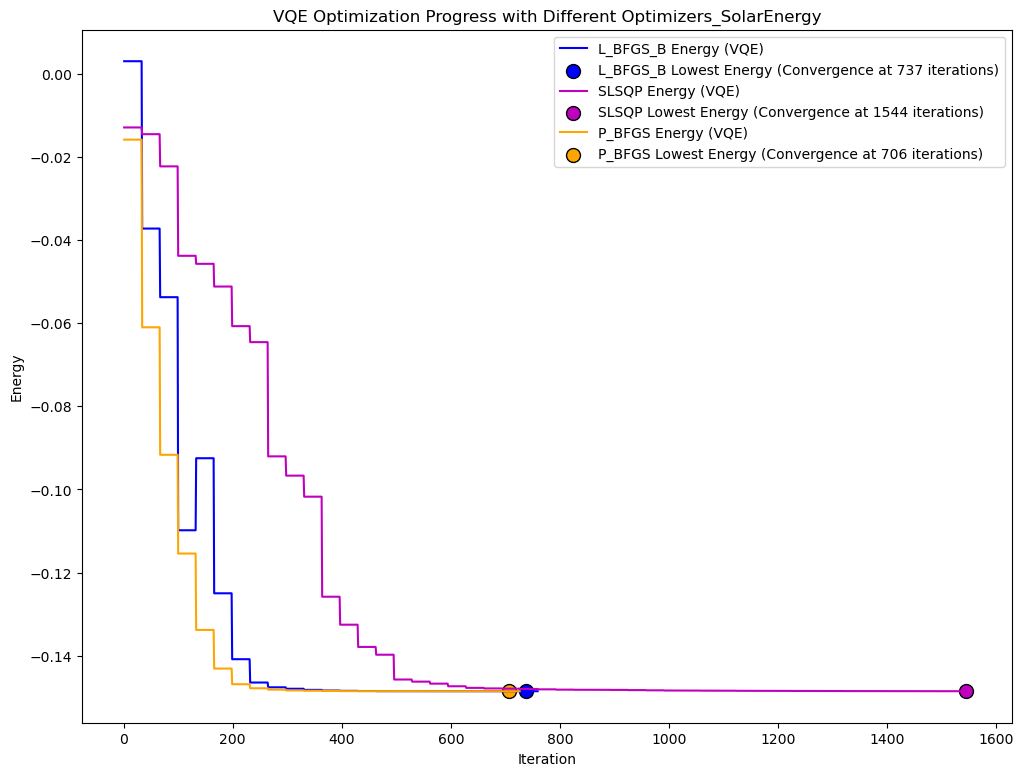


Maximum Eigenvalue Data with Corresponding CSV Rows for Each Optimizer:

Optimizer: L_BFGS_B
  Maximum Eigenvalue: 0.003008880568685507
  Reached at Iteration: 27
  Corresponding CSV Data Point: {'G_theta': 924.0, 'T': 30.0, 'V_oc': 87.94, 'I_sc': 20.924904}

Optimizer: SLSQP
  Maximum Eigenvalue: -0.01292382703146775
  Reached at Iteration: 2
  Corresponding CSV Data Point: {'G_theta': 156.0, 'T': 27.0, 'V_oc': 89.74, 'I_sc': 3.0436224}

Optimizer: P_BFGS
  Maximum Eigenvalue: -0.015856928185388725
  Reached at Iteration: 18
  Corresponding CSV Data Point: {'G_theta': 780.0, 'T': 29.0, 'V_oc': 88.54, 'I_sc': 16.848624}


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator 
from qiskit import QuantumCircuit
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import L_BFGS_B, SLSQP, P_BFGS
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Pauli
from qiskit.primitives import Estimator
from qiskit_ibm_runtime import QiskitRuntimeService, Options

# Read CSV File containing values of V_oc, I_sc, T, and G(theta)
csv_file_path = "E:/Solar and Wind Integration/Second Paper/solar_panel_data.csv"
data = pd.read_csv(csv_file_path)

# Extract data columns
V_oc_values = data['V_oc'].values
I_sc_values = data['I_sc'].values
T_values = data['T'].values
G_theta_values = data['G_theta'].values

# Constants for the power output equation
T_ref = 25
G_ref = 1000
R = 0.700
r_s = 18.15
k_V = -0.24
k_I = 0.04

# Objective function to calculate power output
def power_output(V_oc, T, I_sc, G_theta):
    V_adjusted = V_oc - k_V * (T - T_ref)
    I_adjusted = I_sc * (G_theta / G_ref) * (1 + k_I * (T - T_ref))
    impedance_factor = R / (R + r_s)
    power = V_adjusted * I_adjusted * impedance_factor
    return power

# Define operators
V_oc_operator = SparsePauliOp.from_list([("ZIII", 1)])
T_operator = SparsePauliOp.from_list([("IZII", 1)])
I_sc_operator = SparsePauliOp.from_list([("IIZI", 1)])
G_theta_operator = SparsePauliOp.from_list([("IIIZ", 1)])
operator = V_oc_operator + T_operator + I_sc_operator + G_theta_operator
impedance_factor = R / (R + r_s)
operator = impedance_factor * operator

# Set up IBM Quantum service
QiskitRuntimeService.save_account(overwrite=True, channel='ibm_quantum', token='a6681e2bb318b723a9f058a25f8d2f8d457ac8a3e5914aa62b913e5fd3c4e9d0bce3024d003177446b4e22d55fea435d40116913fd252e2acab39203d41d2cbd')
service = QiskitRuntimeService()
backend = service.backend('ibm_sherbrooke')
options = Options(optimization_level=3)

# Track data
iteration_data = {}
convergence_data = {}

def callback(eval_count, parameters, mean, std, optimizer_name):
    if optimizer_name not in iteration_data:
        iteration_data[optimizer_name] = []
    iteration_data[optimizer_name].append((eval_count, mean))

    # Track the lowest energy for convergence detection
    if optimizer_name not in convergence_data:
        convergence_data[optimizer_name] = {"lowest_energy": mean, "iterations_to_convergence": eval_count}
    elif mean < convergence_data[optimizer_name]["lowest_energy"]:
        convergence_data[optimizer_name] = {"lowest_energy": mean, "iterations_to_convergence": eval_count}

    #print(f"Iteration {eval_count} (Optimizer: {optimizer_name}): Energy = {mean}, Parameters = {parameters}")

# Run VQE
def run_vqe(optimizer, optimizer_name):
    iteration_data[optimizer_name] = []
    var_form = TwoLocal(rotation_blocks=['ry', 'rz'], entanglement_blocks='cz', reps=3, entanglement='full')
    estimator = Estimator()
    vqe_instance = VQE(estimator, var_form, optimizer, callback=lambda ec, p, m, s: callback(ec, p, m, s, optimizer_name))
    return vqe_instance.compute_minimum_eigenvalue(operator)

# Optimizers
optimizers = {
    'L_BFGS_B': L_BFGS_B(maxiter=100),
    'SLSQP': SLSQP(maxiter=100),
    'P_BFGS': P_BFGS(options={'maxiter': 100})
}

# Run VQE with each optimizer
vqe_results = {}
for optimizer_name, optimizer in optimizers.items():
    vqe_results[optimizer_name] = run_vqe(optimizer, optimizer_name)

# Plot results
colors = {'L_BFGS_B': 'b', 'SLSQP': 'm', 'P_BFGS': 'orange'}
plt.figure(figsize=(12, 9))

for optimizer_name, data in iteration_data.items():
    iterations, energies = zip(*data)
    plt.plot(iterations, energies, label=f'{optimizer_name} Energy (VQE)', color=colors[optimizer_name])

    # Highlight lowest energy point
    lowest_energy = convergence_data[optimizer_name]["lowest_energy"]
    convergence_iteration = convergence_data[optimizer_name]["iterations_to_convergence"]
    plt.scatter(convergence_iteration, lowest_energy, color=colors[optimizer_name], marker='o', s=100, edgecolor='black',
                label=f'{optimizer_name} Lowest Energy (Convergence at {convergence_iteration} iterations)')

plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('VQE Optimization Progress with Different Optimizers_SolarEnergy')
plt.legend()
plt.savefig("vqe_optimization_solar_3o3.svg", dpi=300)
plt.show()

# Classical comparison
classical_power_outputs = [power_output(V_oc, T, I_sc, G_theta) for V_oc, I_sc, T, G_theta in zip(V_oc_values, I_sc_values, T_values, G_theta_values)]


csv_data = pd.read_csv("E:/Solar and Wind Integration/Second Paper/solar_panel_data.csv")

print("\nMaximum Eigenvalue Data with Corresponding CSV Rows for Each Optimizer:")

# Iterate through each optimizer's data
for optimizer_name, data in iteration_data.items():
    iterations, eigenvalues = zip(*data)  # Unpack iterations and eigenvalues
    local_max_eigenvalue = max(eigenvalues)
    local_max_iteration = iterations[eigenvalues.index(local_max_eigenvalue)]
    
    # Map the maximum eigenvalue to the corresponding CSV row
    csv_row_index = local_max_iteration - 1  # Adjust for 0-based indexing
    
    print(f"\nOptimizer: {optimizer_name}")
    print(f"  Maximum Eigenvalue: {local_max_eigenvalue}")
    print(f"  Reached at Iteration: {local_max_iteration}")
    
    if isinstance(csv_data, list):
        # Handle csv_data as a list of rows
        if 0 <= csv_row_index < len(csv_data):
            csv_row = csv_data[csv_row_index]
            print(f"  Corresponding CSV Data Point: {csv_row}")
        else:
            print("  Corresponding CSV Data Point: Not Found (Iteration out of CSV range)")
    elif isinstance(csv_data, pd.DataFrame):
        # Handle csv_data as a pandas DataFrame
        if 0 <= csv_row_index < len(csv_data):
            csv_row = csv_data.iloc[csv_row_index]
            print(f"  Corresponding CSV Data Point: {csv_row.to_dict()}")
        else:
            print("  Corresponding CSV Data Point: Not Found (Iteration out of CSV range)")
    else:
        print("  Unknown CSV Data Format!")

